# Linear Regression - Updated

The following notebook deviates from the original "Linear Regression" notebook since we are trying to predict closing stock price from today's opening stock price. This will be done by using yesterday's stock prices and other features that can be found along the way such as using relative strength index and simple moving averages (traditional methods). 

### Data Exploration

In [1]:
%pip install pandas==1.4.1

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pickle

We will be using cleaned data from the **Features and Financial Indicators from yfinance** notebook. All the features are floats: "Open", "High", "Low", "Close", "Volume", "Stock Splits", and "Date". The data ranges from 

In [3]:
#original features that weren't scaled
msft_prices = pd.read_pickle('msft_prices.pkl')
#features that were scaled with the MinMaxScaler()
msft_features = pd.read_pickle('msft_features.pkl')

In [4]:
msft_prices.head()

,Open,High,Low,Close,Volume,Stock Splits,Date
0,48.972503,49.341801,48.423059,49.224709,24944300.0,0.0,2016-04-12
1,49.648050,49.936283,49.440884,49.855217,20818000.0,0.0,2016-04-13
2,49.738134,50.062396,49.603023,49.864235,20877100.0,0.0,2016-04-14
3,49.810182,50.368632,49.639045,50.125439,28793800.0,0.0,2016-04-15
4,49.981320,50.972118,49.729114,50.855022,23786000.0,0.0,2016-04-18


In [5]:
msft_features.head()

,Open,High,Low,Close,Volume,Stock Splits,distance_from_nearest_cluster
0,0.015533,0.015820,0.016461,0.017948,0.138952,0.0,0.291281
1,0.017814,0.017795,0.019916,0.020085,0.106224,0.0,0.291286
2,0.018118,0.018214,0.020466,0.020115,0.106692,0.0,0.290554
3,0.018361,0.019232,0.020589,0.021000,0.169485,0.0,0.283350
4,0.018939,0.021237,0.020894,0.023472,0.129765,0.0,0.282966


In [6]:
msft_features.isnull().sum().sum()

0

In [7]:
msft_prices.isnull().sum().sum()

0

There are no null values in both the features and prices dataframe. We will have to shift data from today's high, low, close, volume, and stock splits to be used to calculate tommorow's closing price in addition when taking tommorow's opening stock price. The premise of the project is to develop a model that will help investors to make a decision on holding or selling Microsoft/or any other corporation's stocks based on when financial markets open + historical data. 

msft_features was scaled by MinMaxScaler(). The labels for this dataframe would be today's closing price. The features of this dataframe would be today's opening stock price along with yesterday's opening, closing, high,low, volume, and stock splits. 

In [8]:
msft_features.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Stock Splits',
       'distance_from_nearest_cluster'],
      dtype='object')

In [9]:
msft_features.pop('distance_from_nearest_cluster')

0       0.291281
1       0.291286
2       0.290554
3       0.283350
4       0.282966
          ...   
1757    0.248251
1758    0.237220
1759    0.244292
1760    0.256056
1761    0.223088
Name: distance_from_nearest_cluster, Length: 1762, dtype: float64

In [10]:
msft_features.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Stock Splits'], dtype='object')

Using today's opening prices with yesterday's features. We have to shift data over and seperate dataframes to get msft_features_update and msft_labels (today's - closing stock price).

### Trying to create a dataframe using yesterday's data along with today's opening stock price

Row 1761 accounts for the latest row in terms of collecting data from different features: 'Open', 'High', 'Low', 'Close', 'Volume', 'Stock Splits'. Row 0 accounts for the first row. We want row 0's data and match that up with row 1's opening stock price with row 1's closing stock price. 

In [11]:
msft_prices_yesterday = msft_prices.copy()
msft_prices_today = msft_prices.copy()


In [12]:
msft_prices_yesterday.head()

,Open,High,Low,Close,Volume,Stock Splits,Date
0,48.972503,49.341801,48.423059,49.224709,24944300.0,0.0,2016-04-12
1,49.648050,49.936283,49.440884,49.855217,20818000.0,0.0,2016-04-13
2,49.738134,50.062396,49.603023,49.864235,20877100.0,0.0,2016-04-14
3,49.810182,50.368632,49.639045,50.125439,28793800.0,0.0,2016-04-15
4,49.981320,50.972118,49.729114,50.855022,23786000.0,0.0,2016-04-18


In [13]:
msft_prices_yesterday.rename(columns={'Open':'past_open','High': 'past_high', 'Low': 'past_low', 'Close':'past_close','Volume':'past_volume','Stock Splits': 'past_stock_splits','Date': 'yesterday'}, inplace=True)

In [14]:
msft_prices_yesterday.head()

,past_open,past_high,past_low,past_close,past_volume,past_stock_splits,yesterday
0,48.972503,49.341801,48.423059,49.224709,24944300.0,0.0,2016-04-12
1,49.648050,49.936283,49.440884,49.855217,20818000.0,0.0,2016-04-13
2,49.738134,50.062396,49.603023,49.864235,20877100.0,0.0,2016-04-14
3,49.810182,50.368632,49.639045,50.125439,28793800.0,0.0,2016-04-15
4,49.981320,50.972118,49.729114,50.855022,23786000.0,0.0,2016-04-18


In [15]:
msft_prices_today.head()

,Open,High,Low,Close,Volume,Stock Splits,Date
0,48.972503,49.341801,48.423059,49.224709,24944300.0,0.0,2016-04-12
1,49.648050,49.936283,49.440884,49.855217,20818000.0,0.0,2016-04-13
2,49.738134,50.062396,49.603023,49.864235,20877100.0,0.0,2016-04-14
3,49.810182,50.368632,49.639045,50.125439,28793800.0,0.0,2016-04-15
4,49.981320,50.972118,49.729114,50.855022,23786000.0,0.0,2016-04-18


We have to shift all of this data to one day over and use the opening stock price as a feature for our label which is closing stock price. We can also delete all the other information except for maybe date. 

In [16]:
msft_prices_today = msft_prices_today.drop([0]).reset_index(drop=True)

In [17]:
msft_prices_today.head()

,Open,High,Low,Close,Volume,Stock Splits,Date
0,49.648050,49.936283,49.440884,49.855217,20818000.0,0.0,2016-04-13
1,49.738134,50.062396,49.603023,49.864235,20877100.0,0.0,2016-04-14
2,49.810182,50.368632,49.639045,50.125439,28793800.0,0.0,2016-04-15
3,49.981320,50.972118,49.729114,50.855022,23786000.0,0.0,2016-04-18
4,51.008153,51.134254,50.152462,50.791977,29596800.0,0.0,2016-04-19


In [18]:
msft_prices_today.count()
msft_prices_yesterday.count()

past_open            1762
past_high            1762
past_low             1762
past_close           1762
past_volume          1762
past_stock_splits    1762
yesterday            1762
dtype: int64

We now shifted data 1 day ahead for the dataframe msft_prices_today. All we need is the opening stock price for an additional feature. 

In [19]:
msft_prices_today.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Stock Splits', 'Date'], dtype='object')

In [20]:
msft_prices_today = msft_prices_today.drop(columns=['High', 'Low', 'Volume', 'Stock Splits'])

In [21]:
msft_prices_today.head()

,Open,Close,Date
0,49.648050,49.855217,2016-04-13
1,49.738134,49.864235,2016-04-14
2,49.810182,50.125439,2016-04-15
3,49.981320,50.855022,2016-04-18
4,51.008153,50.791977,2016-04-19


In [22]:
msft_prices_copy = msft_prices_today.copy()

In [23]:
msft_prices_copy.head()

,Open,Close,Date
0,49.648050,49.855217,2016-04-13
1,49.738134,49.864235,2016-04-14
2,49.810182,50.125439,2016-04-15
3,49.981320,50.855022,2016-04-18
4,51.008153,50.791977,2016-04-19


In [24]:
msft_prices_copy.pop("Open")

0        49.648050
1        49.738134
2        49.810182
3        49.981320
4        51.008153
           ...    
1756    287.230011
1757    285.850006
1758    283.209991
1759    289.209991
1760    285.750000
Name: Open, Length: 1761, dtype: float64

In [25]:
msft_prices_copy = msft_prices_copy[msft_prices_copy['Date'] <= '2019-12-31']


In [26]:
msft_prices_copy.tail()

,Close,Date
932,152.619812,2019-12-24
933,153.870773,2019-12-26
934,154.152023,2019-12-27
935,152.823456,2019-12-30
936,152.930145,2019-12-31


In [27]:
msft_prices_copy.to_pickle('msft_labels_updated.pkl')

In [28]:
msft_prices_today.rename(columns={'Open': 'curr_open','Close':'curr_close','Date':'today'}, inplace=True)

I used past to reference the past features and curr to reference today's features (only 1 - opening stock price). 

In [29]:
msft_prices_today.head()
msft_labels = msft_prices_today.pop('curr_close')

In [30]:
msft_prices_today.head()
msft_labels.head()

0    49.855217
1    49.864235
2    50.125439
3    50.855022
4    50.791977
Name: curr_close, dtype: float64

Joining the two datafames from msft_prices_yesterday and msft_prices_today requires the rows to be the same. I can delete the last row from the msft_prices_yesterday since that includes the stock prices of closing date from the latest row in msft_prices-today. 

In [31]:
msft_prices_yesterday = msft_prices_yesterday.drop(msft_prices_yesterday.index[-1])

In [32]:
msft_prices_yesterday.head()

,past_open,past_high,past_low,past_close,past_volume,past_stock_splits,yesterday
0,48.972503,49.341801,48.423059,49.224709,24944300.0,0.0,2016-04-12
1,49.648050,49.936283,49.440884,49.855217,20818000.0,0.0,2016-04-13
2,49.738134,50.062396,49.603023,49.864235,20877100.0,0.0,2016-04-14
3,49.810182,50.368632,49.639045,50.125439,28793800.0,0.0,2016-04-15
4,49.981320,50.972118,49.729114,50.855022,23786000.0,0.0,2016-04-18


In [33]:
msft_prices_yesterday.count

<bound method DataFrame.count of        past_open   past_high    past_low  past_close  past_volume  \
0      48.972503   49.341801   48.423059   49.224709   24944300.0   
1      49.648050   49.936283   49.440884   49.855217   20818000.0   
2      49.738134   50.062396   49.603023   49.864235   20877100.0   
3      49.810182   50.368632   49.639045   50.125439   28793800.0   
4      49.981320   50.972118   49.729114   50.855022   23786000.0   
...          ...         ...         ...         ...          ...   
1756  286.519989  288.269989  283.950012  287.230011   24883300.0   
1757  287.230011  290.450012  285.670013  287.179993   25824300.0   
1758  285.850006  287.149994  282.920013  284.339996   22064800.0   
1759  283.209991  292.079987  282.029999  291.600006   29770300.0   
1760  289.209991  289.600006  284.709991  289.390015   23103000.0   

      past_stock_splits   yesterday  
0                   0.0  2016-04-12  
1                   0.0  2016-04-13  
2                   0.0 

In [34]:
msft_features_updated = pd.merge(msft_prices_yesterday, msft_prices_today, left_index=True, right_index=True)

In [35]:
msft_features_updated.head()

,past_open,past_high,past_low,past_close,past_volume,past_stock_splits,yesterday,curr_open,today
0,48.972503,49.341801,48.423059,49.224709,24944300.0,0.0,2016-04-12,49.648050,2016-04-13
1,49.648050,49.936283,49.440884,49.855217,20818000.0,0.0,2016-04-13,49.738134,2016-04-14
2,49.738134,50.062396,49.603023,49.864235,20877100.0,0.0,2016-04-14,49.810182,2016-04-15
3,49.810182,50.368632,49.639045,50.125439,28793800.0,0.0,2016-04-15,49.981320,2016-04-18
4,49.981320,50.972118,49.729114,50.855022,23786000.0,0.0,2016-04-18,51.008153,2016-04-19


Converting the "2016-04-12" into DateTime format so that we can add this with twitter data from Kaggle or Tweepy. 

In [36]:
msft_features_updated[['yesterday', 'today']] = msft_features_updated[['yesterday', 'today']].apply(pd.to_datetime)

In [37]:
msft_features_updated.head()

,past_open,past_high,past_low,past_close,past_volume,past_stock_splits,yesterday,curr_open,today
0,48.972503,49.341801,48.423059,49.224709,24944300.0,0.0,2016-04-12,49.648050,2016-04-13
1,49.648050,49.936283,49.440884,49.855217,20818000.0,0.0,2016-04-13,49.738134,2016-04-14
2,49.738134,50.062396,49.603023,49.864235,20877100.0,0.0,2016-04-14,49.810182,2016-04-15
3,49.810182,50.368632,49.639045,50.125439,28793800.0,0.0,2016-04-15,49.981320,2016-04-18
4,49.981320,50.972118,49.729114,50.855022,23786000.0,0.0,2016-04-18,51.008153,2016-04-19


In [38]:
msft_features_updated.to_pickle('msft_features_updated.pkl')
msft_labels.to_pickle('msft_labels.pkl')

In [39]:
msft_features_updated.columns

Index(['past_open', 'past_high', 'past_low', 'past_close', 'past_volume',
       'past_stock_splits', 'yesterday', 'curr_open', 'today'],
      dtype='object')

### Scaling our data using StandardScaler

We should scale our features using the MinMaxScaler before running linear regression or other classifiers on this data.

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
 
msft_scaled_features = msft_features_updated.copy()

to_scale = ['past_open', 'past_high', 'past_low', 'past_close', 'past_volume',
       'past_stock_splits', 'curr_open']

msft_scaled_features[to_scale] = scaler.fit_transform(msft_scaled_features[to_scale])
msft_scaled_features.head()

,past_open,past_high,past_low,past_close,past_volume,past_stock_splits,yesterday,curr_open,today
0,-1.281909,-1.281896,-1.283973,-1.279230,-0.318316,0.0,2016-04-12,-1.275513,2016-04-13
1,-1.274124,-1.275123,-1.272102,-1.271966,-0.639944,0.0,2016-04-13,-1.274475,2016-04-14
2,-1.273086,-1.273687,-1.270211,-1.271863,-0.635337,0.0,2016-04-14,-1.273645,2016-04-15
3,-1.272256,-1.270198,-1.269790,-1.268854,-0.018263,0.0,2016-04-15,-1.271673,2016-04-18
4,-1.270284,-1.263323,-1.268740,-1.260449,-0.408600,0.0,2016-04-18,-1.259842,2016-04-19


In [41]:
msft_scaled_features.to_pickle('msft_scaled_features.pkl')

Ran into some problems when trying to train the data because of the DateTime features. Will remove them and create a new dataframe to solve this issue. 

In [42]:
msft_scale_df = msft_scaled_features.copy()
msft_scale_df = msft_scale_df.drop(columns=['yesterday', 'today'])
msft_scale_df.head()

,past_open,past_high,past_low,past_close,past_volume,past_stock_splits,curr_open
0,-1.281909,-1.281896,-1.283973,-1.279230,-0.318316,0.0,-1.275513
1,-1.274124,-1.275123,-1.272102,-1.271966,-0.639944,0.0,-1.274475
2,-1.273086,-1.273687,-1.270211,-1.271863,-0.635337,0.0,-1.273645
3,-1.272256,-1.270198,-1.269790,-1.268854,-0.018263,0.0,-1.271673
4,-1.270284,-1.263323,-1.268740,-1.260449,-0.408600,0.0,-1.259842


### Splitting Data into training, test, and validation datasets

In [43]:
from sklearn.model_selection import train_test_split

features = msft_scale_df.to_numpy()
labels = msft_labels.to_numpy()

print (f"Features' shape [no. of examples * feature vector size] =  {features.shape}")
print (f"Label's shape [no. of examples * 1] = {labels.shape}")

Features' shape [no. of examples * feature vector size] =  (1761, 7)
Label's shape [no. of examples * 1] = (1761,)


Following the conventional standards, we put aside 10% of our dataframe for testing.

In [44]:
# First derive the test data
x_, x_test, y_, y_test = train_test_split(features, labels, test_size=0.10, random_state=42)

# Then create the validation data
x_train, x_valid, y_train, y_valid = train_test_split(x_, y_, test_size=0.10, random_state=42)

print (f"Training: Features' shape [no. of examples * feature vector size] =  {x_train.shape}")
print (f"Training: Label's shape [no. of examples * 1] = {y_train.shape}")

print (f"Validation: Features' shape [no. of examples * feature vector size] =  {x_valid.shape}")
print (f"Validation: Label's shape [no. of examples * 1] = {y_valid.shape}")

print (f"Test: Features' shape [no. of examples * feature vector size] =  {x_test.shape}")
print (f"Test: Label's shape [no. of examples * 1] = {y_test.shape}")

Training: Features' shape [no. of examples * feature vector size] =  (1425, 7)
Training: Label's shape [no. of examples * 1] = (1425,)
Validation: Features' shape [no. of examples * feature vector size] =  (159, 7)
Validation: Label's shape [no. of examples * 1] = (159,)
Test: Features' shape [no. of examples * feature vector size] =  (177, 7)
Test: Label's shape [no. of examples * 1] = (177,)


In [45]:
x_test

array([[ 0.22751941,  0.20921592,  0.20806256, ...,  1.40573815,
         0.        ,  0.1980089 ],
       [ 1.44708815,  1.42631996,  1.34480612, ...,  0.62713669,
         0.        ,  1.32099385],
       [ 1.1251312 ,  1.15135141,  1.12684431, ..., -0.51626709,
         0.        ,  1.18576602],
       ...,
       [-1.05364441, -1.06042365, -1.05251533, ..., -0.76751007,
         0.        , -1.05775259],
       [ 1.27084441,  1.26307368,  1.26460804, ...,  0.6858923 ,
         0.        ,  1.29966941],
       [ 0.92684451,  0.90593508,  0.87211854, ..., -0.02933915,
         0.        ,  0.86599162]])

### Training a Linear Regression Model

In [46]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

regression = LinearRegression(copy_X=True)
y_train = y_train.flatten()

# training 
regression = regression.fit(x_train, y_train)

print ("Training complete")

Training complete


### Evaluating the Model

In [47]:
import sklearn.metrics as metrics
from scipy.stats import pearsonr

# perform prediction on test data
y_test = y_test.flatten()
y_test_predicted = regression.predict(x_test)

mean_squared_error=metrics.mean_squared_error(y_test, y_test_predicted)
mean_absolute_error=metrics.mean_absolute_error(y_test, y_test_predicted)
correlation = pearsonr(y_test, y_test_predicted)

print (f"Mean Squared Error on training data {mean_squared_error}")
print (f"Mean Absolute Error on training data {mean_absolute_error}")
print (f"Pearson correlation coefficient between actual and predicted values is {correlation}")

Mean Squared Error on training data 7.310111809620507
Mean Absolute Error on training data 1.7839708932472975
Pearson correlation coefficient between actual and predicted values is PearsonRResult(statistic=0.9995463581676146, pvalue=3.7488289576473196e-268)


In [48]:
print(y_test)
print(y_test_predicted)

[178.15342712 281.70639038 258.43109131 133.31478882 181.58641052
 168.90628052 331.03128052 278.08190918 326.70278931 258.01873779
 256.27810669  69.10935974  82.87052917  67.6646347   98.49612427
 102.40735626  59.37524033  58.80609894  60.06855011  48.70733261
 154.21990967 133.50746155 131.55517578 247.71234131 102.34475708
 107.83242798  51.31049728 121.38967896  57.8504982  239.70239258
 279.67453003 155.80801392 228.52761841  83.72531891 112.83248901
  52.25091934  88.58269501  46.79350662 244.07865906  67.42289734
 139.42224121  81.14208984 134.68652344 234.72618103 278.14578247
  51.93149185  88.78088379 104.31435394 307.5506897  293.21835327
 285.17892456 240.0088501   88.57324219 238.72444153 263.05792236
  80.62545776  68.47379303  69.73558807  69.54865265 108.86260986
 241.16461182  46.68466187  59.68954086 103.84812927 296.1086731
 230.3553772  155.76177979 198.77627563 190.29278564 293.22113037
 136.33917236 292.74487305 160.57279968 106.81685638  68.47379303
  99.933448

Although the accuracy for this model is pretty high, it may be because of collinearity/overfitting or some other factors. Collinearity seems like a likely factor since all of these features somewhat relate to each other and don't deviate that much. We will try to answer questions by putting this through other classifiers and adding other features such as simple moving average as well as relative strength index. 

MAE states that our predictions don't deviate from the real values by much : Mean Absolute Error on training data 1.7839708932472855.

Let's try to predict the most recent stock prices today from Microsoft.

In [49]:
import yfinance as yf
yf.pdr_override() 
msft = yf.Ticker("msft")

predict_sample = msft.history(start="2023-04-13", end="2023-04-25")

In [50]:
predict_sample.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-13 00:00:00-04:00,283.589996,289.899994,283.170013,289.839996,24222700,0.0,0.0
2023-04-14 00:00:00-04:00,287.000000,288.480011,283.690002,286.140015,20973900,0.0,0.0
2023-04-17 00:00:00-04:00,289.929993,291.600006,286.160004,288.799988,23836200,0.0,0.0
2023-04-18 00:00:00-04:00,291.570007,291.760010,287.010010,288.369995,20161800,0.0,0.0
2023-04-19 00:00:00-04:00,285.989990,289.049988,284.540009,288.450012,17150300,0.0,0.0


I have to transform this data into the following format that I did before. 

In [51]:
predict_sample.dropna()
predict_sample['Volume'] = predict_sample['Volume'].map(float)
predict_sample['Date'] = predict_sample.index

predict_sample = predict_sample.reset_index(drop=True)
predict_sample.pop("Dividends")
predict_sample.head()

,Open,High,Low,Close,Volume,Stock Splits,Date
0,283.589996,289.899994,283.170013,289.839996,24222700.0,0.0,2023-04-13 00:00:00-04:00
1,287.000000,288.480011,283.690002,286.140015,20973900.0,0.0,2023-04-14 00:00:00-04:00
2,289.929993,291.600006,286.160004,288.799988,23836200.0,0.0,2023-04-17 00:00:00-04:00
3,291.570007,291.760010,287.010010,288.369995,20161800.0,0.0,2023-04-18 00:00:00-04:00
4,285.989990,289.049988,284.540009,288.450012,17150300.0,0.0,2023-04-19 00:00:00-04:00


In [52]:
predict_sample_yesterday = predict_sample.copy()
predict_sample_today = predict_sample.copy()

predict_sample_yesterday.rename(columns={'Open':'past_open','High': 'past_high', 'Low': 'past_low', 'Close':'past_close','Volume':'past_volume','Stock Splits': 'past_stock_splits','Date': 'yesterday'}, inplace=True)
predict_sample_today = predict_sample_today.drop([0]).reset_index(drop=True)

predict_sample_today = predict_sample_today.drop(columns=['High', 'Low', 'Volume', 'Stock Splits'])

predict_sample_today.rename(columns={'Open': 'curr_open','Close':'curr_close','Date':'today'}, inplace=True)

predict_sample_today.head()
predict_sample_labels = predict_sample_today.pop('curr_close')

predict_sample_yesterday = predict_sample_yesterday.drop(predict_sample_yesterday.index[-1])

predict_sample_updated = pd.merge(predict_sample_yesterday,predict_sample_today, left_index=True, right_index=True)

predict_scaled_features = predict_sample_updated.copy()
predict_scaled_features[to_scale] = scaler.fit_transform(predict_scaled_features[to_scale])
predict_scaled_features.head()

,past_open,past_high,past_low,past_close,past_volume,past_stock_splits,yesterday,curr_open,today
0,-1.252222,0.261350,-1.074907,1.479413,1.139722,0.0,2023-04-13 00:00:00-04:00,0.104569,2023-04-14 00:00:00-04:00
1,0.035608,-0.547940,-0.702986,-1.007068,-0.276297,0.0,2023-04-14 00:00:00-04:00,1.097489,2023-04-17 00:00:00-04:00
2,1.142157,1.230238,1.063675,0.780501,0.971262,0.0,2023-04-17 00:00:00-04:00,1.653259,2023-04-18 00:00:00-04:00
3,1.761529,1.321428,1.671639,0.491535,-0.630259,0.0,2023-04-18 00:00:00-04:00,-0.237704,2023-04-19 00:00:00-04:00
4,-0.345834,-0.223093,-0.095022,0.545309,-1.942849,0.0,2023-04-19 00:00:00-04:00,-0.488473,2023-04-20 00:00:00-04:00


In [53]:
predict_scale_df = predict_scaled_features.copy()
predict_scale_df = predict_scale_df.drop(columns=['yesterday', 'today'])
predict_scale_df.head()

,past_open,past_high,past_low,past_close,past_volume,past_stock_splits,curr_open
0,-1.252222,0.261350,-1.074907,1.479413,1.139722,0.0,0.104569
1,0.035608,-0.547940,-0.702986,-1.007068,-0.276297,0.0,1.097489
2,1.142157,1.230238,1.063675,0.780501,0.971262,0.0,1.653259
3,1.761529,1.321428,1.671639,0.491535,-0.630259,0.0,-0.237704
4,-0.345834,-0.223093,-0.095022,0.545309,-1.942849,0.0,-0.488473


In [54]:
predict_features = predict_scale_df.to_numpy()

In [55]:
prediction_scores = regression.predict(predict_features)

In [56]:
predict_labels = predict_sample_labels.to_numpy()
mean_squared_error=metrics.mean_squared_error(predict_labels, prediction_scores)
mean_absolute_error=metrics.mean_absolute_error(predict_labels, prediction_scores)
correlation = pearsonr(predict_labels, prediction_scores)

print (f"Mean Squared Error on training data {mean_squared_error}")
print (f"Mean Absolute Error on training data {mean_absolute_error}")
print (f"Pearson correlation coefficient between actual and predicted values is {correlation}")

Mean Squared Error on training data 24056.032842629964
Mean Absolute Error on training data 132.73163686868563
Pearson correlation coefficient between actual and predicted values is PearsonRResult(statistic=0.8345970445680753, pvalue=0.019507570483132626)


In [57]:
print(prediction_scores)
print(predict_labels)

[146.92587183 272.60152532 311.64716013 145.2377079  105.91215842
 117.26428417  23.24415808]
[286.14001465 288.79998779 288.36999512 288.45001221 286.10998535
 285.76000977 281.76998901]


We now know that our data doesn't perform that well on unseen data which is an indication that our model is performing poorly because of collinearity/overfitting. This makes sense though considering the scaling. 

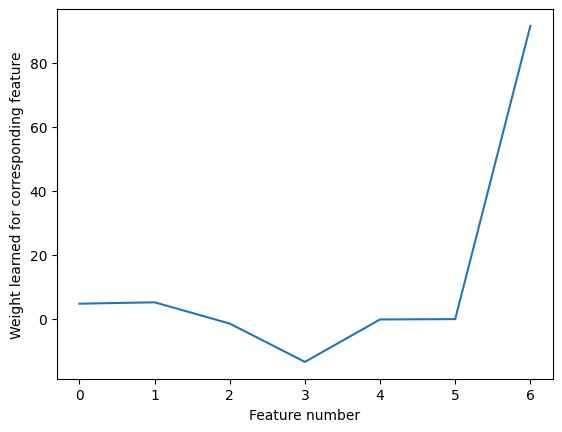

[  4.81692845   5.24625855  -1.39290479 -13.36177355  -0.10294006
   0.          91.51446556]


In [62]:
from matplotlib import pyplot as plt

weights = regression.coef_
plt.plot(range(len(weights)), weights)
plt.xlabel("Feature number")
plt.ylabel("Weight learned for corresponding feature")
plt.show()
print(weights)

In [61]:
predict_scale_df.columns

Index(['past_open', 'past_high', 'past_low', 'past_close', 'past_volume',
       'past_stock_splits', 'curr_open'],
      dtype='object')

The linear regression coefficient weights seems to say that **past_open, past_high, past_low, past_volume, and past_stock_splits** have the **least** amount of influence on the target variable - today's closing stock price. The **strongest positive coefficient is curr_open** which indicates that an in increase in curr_open would lead to an increase in curr_close. The **strongest negative coefficient is past_close** which suggests than an increase in past_close would lead to a decrease in curr_close. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6f501a8e-f6e4-43a9-b4a2-6516b2e3d333' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>